# 1 Preparations

In [1]:
import monkdata as m
import dtree as d
import drawtree_qt5 as dt
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# 2 MONK datasets

## Assignment 0
>Each one of the datasets has properties which makes
them hard to learn. Motivate which of the three problems is most
difficult for a decision tree algorithm to learn.

- independent variables. In MONK-3 variables are basically independent of each other. MONK-1 a1=a2 creates a dependency. MONK-2 all of them are dependent
- meaningful number of attributes:
    - MONK-1: 3
    - MONK-2: 6
    - MONK-3: 3
- values that control the whole branch, like a5 = 1 (in MONK-1) or a5 = 4 (in MONK-3). The value of this attribute is enough to compute the result of that branch
- MONK-1 and MONK-3 are relatively easy to express with predicate calculus, but MONK-2 is not. This means that it is hard to model with decision trees because it is hard to express and thus we need lots of data to model it.
      

# 3 Entropy

## Assignment 1
>The file dtree.py defines a function entropy which
calculates the entropy of a dataset. Import this file along with the
monks datasets and use it to calculate the entropy of the training
datasets.


In [2]:
train_sets = [m.monk1, m.monk2, m.monk3]
train_entropies = []

for dataset in train_sets:
    train_entropies.append(d.entropy(dataset))

In [3]:
print(train_entropies)

[1.0, 0.957117428264771, 0.9998061328047111]


## Assignment 2
>Explain entropy for a uniform distribution and a
non-uniform distribution, present some example distributions with
high and low entropy.

Entropy measures the level of uncertainty of something. So, in a uniform distribution, the entropy will always be maximum because all events have equal probability of happening, whereas, in non-uniform distributions, some events have more probability of happening, which is saying that the level of uncertainty is lower. For example. if you flip a coin, both outcomes have the same probability, which is 0.5. So, the entropy will be

    -0.5\*log2(0.5) -0.5\*log2(0.5) = 0.5 + 0.5 = 1

On the other hand, if you have a bag with 3 balls inside, where one of them is red and the other two are blue, then it's expectable that the probability of randomly taking out a blue ball it's higher (actually 2/3). Therefore, the level of uncertainty is lower and consequently the entropy is also lower. Here is the maths to show it:

    -0.33\*log2(0.33) -0.66\*log2(0.66) = 0.5278 + 0.3956 = 0.9234

# 4 Information Gain

## Assignment 3
>Use the function averageGain (defined in dtree.py)
to calculate the expected information gain corresponding to each of
the six attributes. Note that the attributes are represented as instances of the class Attribute (defined in monkdata.py) which you
can access via m.attributes[0], ..., m.attributes[5]. Based on
the results, which attribute should be used for splitting the examples
at the root node?

In [5]:
attr_gains_datasets = []
for dataset in train_sets:
    attr_gains = []
    for attribute in m.attributes:
        avg_gain = d.averageGain(dataset, attribute)
        attr_gains.append(avg_gain)
    attr_gains_datasets.append(attr_gains)

In [6]:
dataset_cntr = 1
max_gains = []

for dataset in attr_gains_datasets:
    print(f"Dataset {dataset_cntr}:")
    #print(f"Best attr: {d.bestAttribute(dataset, dataset.)}")
    attr_cntr = 1
    for attribute_gain in dataset:
        print(f"\tA{attr_cntr} gain: {attribute_gain}")
        attr_cntr += 1
    dataset_cntr += 1
    max_gains.append(max(dataset))


Dataset 1:
	A1 gain: 0.07527255560831925
	A2 gain: 0.005838429962909286
	A3 gain: 0.00470756661729721
	A4 gain: 0.02631169650768228
	A5 gain: 0.28703074971578435
	A6 gain: 0.0007578557158638421
Dataset 2:
	A1 gain: 0.0037561773775118823
	A2 gain: 0.0024584986660830532
	A3 gain: 0.0010561477158920196
	A4 gain: 0.015664247292643818
	A5 gain: 0.01727717693791797
	A6 gain: 0.006247622236881467
Dataset 3:
	A1 gain: 0.007120868396071844
	A2 gain: 0.29373617350838865
	A3 gain: 0.0008311140445336207
	A4 gain: 0.002891817288654397
	A5 gain: 0.25591172461972755
	A6 gain: 0.007077026074097326


Based on expected information gain, the following attributes should be used:
- MONK-1: A5
- MONK-2: A5 (even though the information gain is marginal)
- MONK-3: A2

## Assignment 4
>For splitting we choose the attribute that maximizes
the information gain, Eq.3. Looking at Eq.3 how does the entropy of
the subsets, Sk, look like when the information gain is maximized?
How can we motivate using the information gain as a heuristic for
picking an attribute for splitting? Think about reduction in entropy
after the split and what the entropy implies.


In [8]:
#Short story
new_entropies = []

for entropy, gain in zip(train_entropies, max_gains):
    new_entropies.append(entropy - gain)

In [9]:
print(new_entropies)

[0.7129692502842156, 0.939840251326853, 0.7060699592963224]


In [9]:
#Long story
sum_entropies = 0
dataset = m.monk1

for i in range(1, 5):
    subset = d.select(dataset, m.attributes[4], i)
    subset_entropy = d.entropy(subset)
    sum_entropies += subset_entropy*(len(subset)/len(dataset))
print(sum_entropies)

0.7129692502842158


Entropy is the level of uncertainty. If the attribute which has the most information gain is chosen for splitting, the uncertainty of the data is decreased in the most optimal way. In practical words, that attribute contributes the most in decision making.

The information gain as a heuristic can help finding attributes which are more important than others. The equation provides a measurable value for that. This is the value the entropy can be decreased with, thus that should be maximized. After finding the most optimal candidate, a decision tree can split the data based on that attribute. This maximizes the difference of the following branches (as the information gain means exactly this - the data is separated the best possible way). This process can be recursively continued - leading to a decision tree which separates the data the best possible way at all levels starting from its root.

This process leads to an algorithm with the highest possible information gain in every level, minimizing the size of the decision tree. But keep in mind that this is a local choice, which means that even if it is the best option locally, it is not always the best globally - it's a greedy algorithm.

# 5 Building Decision Trees

>Split the monk1 data into subsets according to the selected attribute using
the function select (again, defined in dtree.py) and compute the information gains for the nodes on the next level of the tree. Which attributes
should be tested for these nodes?

In [46]:
def createSubsets(dataset, attribute):
    split_attr = attribute
    distinct_values = split_attr.values

    subsets = []
    for value in distinct_values:
        subsets.append(d.select(dataset, split_attr, value))
    return subsets

In [47]:
# split based on the distinct values of A5 (indices from 0..5 -> A5=4)
monk1_subsets = createSubsets(m.monk1, m.attributes[4])

cntr_subset = 1
for subset in monk1_subsets:
    print(f"Subset {cntr_subset}:")
    attr_cntr = 1
    for attribute in m.attributes:
        avg_gain = d.averageGain(subset, attribute)
        print(f"\tA{attr_cntr} gain: {avg_gain}")
        attr_cntr += 1
    cntr_subset += 1

Subset 1:
	A1 gain: 0.0
	A2 gain: 0.0
	A3 gain: 0.0
	A4 gain: 0.0
	A5 gain: 0.0
	A6 gain: 0.0
Subset 2:
	A1 gain: 0.040216841609413634
	A2 gain: 0.015063475072186083
	A3 gain: 0.03727262736015946
	A4 gain: 0.04889220262952931
	A5 gain: 0.0
	A6 gain: 0.025807284723902146
Subset 3:
	A1 gain: 0.03305510013455182
	A2 gain: 0.002197183539100922
	A3 gain: 0.017982293842278896
	A4 gain: 0.01912275517747053
	A5 gain: 0.0
	A6 gain: 0.04510853782483648
Subset 4:
	A1 gain: 0.20629074641530198
	A2 gain: 0.033898395077640586
	A3 gain: 0.025906145434984817
	A4 gain: 0.07593290844153944
	A5 gain: 0.0
	A6 gain: 0.0033239629631565126


The following attributes should be tested on the next level:
- Subset 1: nothing (as this subset already contains the same Y labels, in this subset of the problem, no matter the value of the attributes, the outcome is always TRUE)
- Subset 2: A4
- Subset 3: A6
- Subset 4: A1

>For the monk1 data draw the decision tree up to the first two levels and
assign the majority class of the subsets that resulted from the two splits
to the leaf nodes. You can use the predefined function mostCommon (in
dtree.py) to obtain the majority class for a dataset.

In [48]:
def monk1DummyTree():
    subsets = createSubsets(m.monk1, m.attributes[4])
    for subset, index in zip(subsets[1:], [3, 5, 0]):
        print(f"Attribute {index+1}:")
        level2_subset = createSubsets(subset, m.attributes[index])
        for subsubset in level2_subset:
            mostCommonChoice = d.mostCommon(subsubset)
            print(mostCommonChoice)

In [54]:
monk1DummyTree()

Attribute 4:
False
False
False
Attribute 6:
False
False
Attribute 1:
False
False
True


![Our tree](tree-draw.jpg)

>Now compare your results with that of a predefined routine for ID3. Use
the function buildTree(data, m.attributes) to build the decision tree.
If you pass a third, optional, parameter to buildTree, you can limit the
depth of the generated tree.

In [53]:
tree = d.buildTree(m.monk1, m.attributes, 2)
#dt.drawTree(tree)

![The resulting decision tree](tree_test.PNG)

## Assignment 5
>Build the full decision trees for all three Monk
datasets using buildTree. Then, use the function check to measure the performance of the decision tree on both the training and
test datasets.
For example to built a tree for monk1 and compute the performance
on the test data you could use
import monkdata as m
import dtree as d
t=d.buildTree(m.monk1, m.attributes);
print(d.check(t, m.monk1test))
Compute the train and test set errors for the three Monk datasets
for the full trees. Were your assumptions about the datasets correct?
Explain the results you get for the training and test datasets.

In [16]:
tree1 = d.buildTree(m.monk1, m.attributes)
tree2 = d.buildTree(m.monk2, m.attributes)
tree3 = d.buildTree(m.monk3, m.attributes)
'''
dt.drawTree(tree1)
dt.drawTree(tree2)
dt.drawTree(tree3)
'''

'\ndt.drawTree(tree1)\ndt.drawTree(tree2)\ndt.drawTree(tree3)\n'

![The resulting decision tree](tree-monk1.PNG)
![The resulting decision tree](tree-monk2.PNG)
![The resulting decision tree](tree-monk3.PNG)

In [17]:
print(f"MONK-1 tree\t\tTrain error: {1-d.check(tree1, m.monk1)}\t\tTest error: {1-d.check(tree1, m.monk1test)}")
print(f"MONK-2 tree\t\tTrain error: {1-d.check(tree2, m.monk2)}\t\tTest error: {1-d.check(tree2, m.monk2test)}")
print(f"MONK-3 tree\t\tTrain error: {1-d.check(tree3, m.monk3)}\t\tTest error: {1-d.check(tree3, m.monk3test)}")

MONK-1 tree		Train error: 0.0		Test error: 0.17129629629629628
MONK-2 tree		Train error: 0.0		Test error: 0.30787037037037035
MONK-3 tree		Train error: 0.0		Test error: 0.05555555555555558


Based on the provided training data, the decision trees have been generated properly (training error = 0 indicates that). Based on the test set errors, it looks like MONK-2 is the dataset where our decision tree approach struggles the most:
- On MONK-1, there is ~17% error rate. With this dataset, attribute 5 produced a significant information gain (~28%) at the beginning. Based on this, this dataset looked like to be relatively efficiently solvable with our approach, which has been confirmed.
- On MONK-2, the error rate is more than 30%. This is however not a surprise, as the information gain looked like to be marginal for each attribute (maximum ~1.7%). The reason is that the relation 'exactly two' is somewhat difficult to express with predicate calculus, so it is also difficult to model. To model it properly, 432 distinct records are needed for each attribute dual combinations (because here, all needs to be properly modelled). But in this training set, there are only 169 records. 
- On MONK-3, the error rate is 5.5%, which is the best out of the three. It is worth mentioning that MONK-3's training set has an additional 5% noise. Without this, the tree would perform even better. The size of the tree suggests that the information gain was significant when slicing the data. This was somehow expected, as both A5 and A2 indicated significant information gains (~25% and ~29%) earlier, so the good performance on this dataset is not a surprise.

# 6 Pruning

In [60]:
import random

def partition(data, fraction):
    ldata = list(data)
    random.shuffle(ldata)
    breakPoint = int(len(ldata) * fraction)
    return ldata[:breakPoint], ldata[breakPoint:]
    
monk1train, monk1val = partition(m.monk1, 0.6)

>Write code which performs the complete pruning by repeatedly calling
allPruned and picking the tree which gives the best classification performance on the validation dataset. You should stop pruning when all the
pruned trees perform worse than the current candidate.

In [70]:
def pruneTree(train, test, fraction):
    accuracies = {}

    train, val = partition(train, fraction)
    best_acc = 0
    prune_level = 0
    level_best_acc = 0

    # original tree
    best_tree = d.buildTree(train, m.attributes)
    level_best_acc = d.check(best_tree, val)
    best_acc = level_best_acc
    current_key = f"l{prune_level}_t0"
    accuracies[current_key] = best_acc

    # while the last level provided the best accuracy so far
    while level_best_acc == best_acc:
        level_best_acc = 0
        prune_level += 1
        pruned_trees = d.allPruned(best_tree)

        for tree_idx in range(0, len(pruned_trees)):
            current_tree = pruned_trees[tree_idx]
            current_acc = d.check(current_tree, val)
            current_key = f"l{prune_level}_t{tree_idx}"

            accuracies[current_key] = current_acc

            if(current_acc >= level_best_acc):
                level_best_acc = current_acc
                if(current_acc >= best_acc):
                    best_acc = current_acc
                    best_tree = current_tree
                    #print(f"new best tree: {best_acc}, {best_tree}")

    return d.check(best_tree, test), max(accuracies.values()), max(accuracies, key=accuracies.get), accuracies

In [71]:
best_acc, best_acc_val, best_id, accs = pruneTree(m.monk1, m.monk1test, 0.6)
print(best_acc)
print(best_acc_val)
print(best_id)
print(accs)

0.8425925925925926
0.92
l0_t0
{'l0_t0': 0.92, 'l1_t0': 0.5, 'l1_t1': 0.88, 'l1_t2': 0.9, 'l1_t3': 0.92, 'l1_t4': 0.9, 'l1_t5': 0.92, 'l1_t6': 0.92, 'l1_t7': 0.9, 'l1_t8': 0.9, 'l1_t9': 0.92, 'l1_t10': 0.9, 'l1_t11': 0.92, 'l1_t12': 0.92, 'l1_t13': 0.86, 'l1_t14': 0.86, 'l1_t15': 0.86, 'l1_t16': 0.84, 'l1_t17': 0.92, 'l1_t18': 0.9, 'l1_t19': 0.86, 'l2_t0': 0.5, 'l2_t1': 0.88, 'l2_t2': 0.9, 'l2_t3': 0.92, 'l2_t4': 0.9, 'l2_t5': 0.92, 'l2_t6': 0.92, 'l2_t7': 0.9, 'l2_t8': 0.9, 'l2_t9': 0.92, 'l2_t10': 0.9, 'l2_t11': 0.92, 'l2_t12': 0.92, 'l2_t13': 0.86, 'l2_t14': 0.86, 'l2_t15': 0.86, 'l2_t16': 0.84, 'l2_t17': 0.9, 'l2_t18': 0.86, 'l3_t0': 0.5, 'l3_t1': 0.88, 'l3_t2': 0.9, 'l3_t3': 0.92, 'l3_t4': 0.9, 'l3_t5': 0.92, 'l3_t6': 0.92, 'l3_t7': 0.9, 'l3_t8': 0.9, 'l3_t9': 0.92, 'l3_t10': 0.9, 'l3_t11': 0.92, 'l3_t12': 0.86, 'l3_t13': 0.86, 'l3_t14': 0.86, 'l3_t15': 0.84, 'l3_t16': 0.9, 'l3_t17': 0.86, 'l4_t0': 0.5, 'l4_t1': 0.88, 'l4_t2': 0.9, 'l4_t3': 0.92, 'l4_t4': 0.9, 'l4_t5': 0.92, 'l4_t6

## Assignment 6
>Explain pruning from a bias variance trade-off perspective.

Pruning reduces the model complexity, since the size of the decision tree is reduced. Since decision trees often has a high variance and low bias, due to the overfitting nature of the model, the variance will thus be reduced by pruning. When variance is reduced, bias is increased. This also makes the model more general and usable.

It is notable that for two equally performing trees, the smaller one should be choosen in order to minimize the risk of overfitting caused by variance.

## Assignment 7
>Evaluate the effect pruning has on the test error for
the monk1 and monk3 datasets, in particular determine the optimal
partition into training and pruning by optimizing the parameter
fraction. Plot the classification error on the test sets as a function
of the parameter fraction ∈ {0.3, 0.4, 0.5, 0.6, 0.7, 0.8}.

>Note that the split of the data is random. We therefore need to
compute the statistics over several runs of the split to be able to draw
any conclusions. Reasonable statistics includes mean and a measure
of the spread. Do remember to print axes labels, legends and data
points as you will not pass without them.

In [73]:
def plotMeanVariance(names, means, variances):

    mean_xs = []
    mean_ys = []
    for mean in means:
        mean_x, mean_y = zip(*sorted(mean.items()))
        mean_xs.append(mean_x)
        mean_ys.append(mean_y)

    variance_xs = []
    variance_ys = []
    for variance in variances:
        variance_x, variance_y = zip(*sorted(variance.items()))
        variance_xs.append(variance_x)
        variance_ys.append(variance_y)

    plt.figure(figsize=(20,5))
    # row, column, plot
    plt.subplot(1, 2, 1)
    for i in range (len(mean_ys)):
        plt.plot(mean_xs[i], mean_ys[i], marker='x')
    plt.title(f"Mean error vs fraction")
    plt.xlabel("fraction")
    plt.ylabel("mean error")
    plt.legend(names)
    plt.subplot(1, 2, 2)
    for i in range (len(variance_ys)):
        plt.plot(variance_xs[i], variance_ys[i], marker='o')
    plt.title(f"Variance vs fraction")
    plt.xlabel("fraction")
    plt.ylabel("variance")
    plt.legend(names)
    plt.show()

In [74]:
def fractionTest(train, test, num_iters):
    mean_errors = {}
    variance = {}

    for i in np.arange(0.3, 0.89, 0.1):
        fraction = round(i, 1)
        accs = np.empty(0)
        for iteration in range(num_iters):
            best_acc, _, _, _ = pruneTree(train, test, fraction)
            accs = np.append(accs, best_acc)
        mean_errors[fraction] = 1-np.mean(accs)
        variance[fraction] = np.var(accs)

    return mean_errors, variance

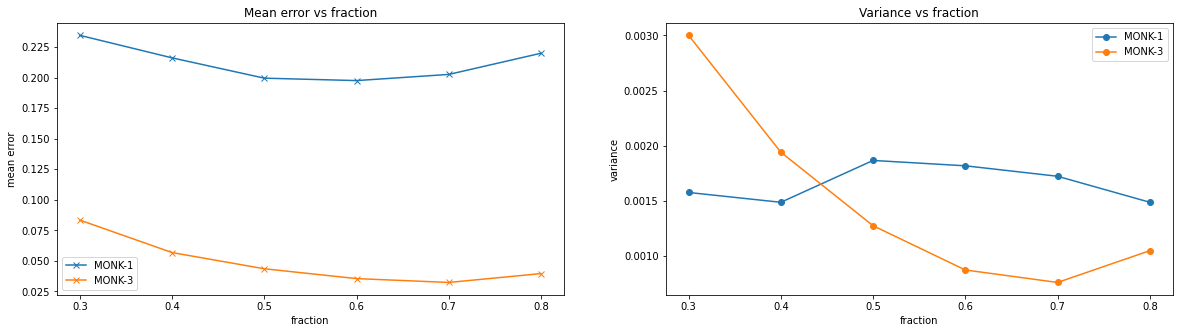

In [75]:
m1_mean, m1_variance = fractionTest(m.monk1, m.monk1test, 1000)
m3_mean, m3_variance = fractionTest(m.monk3, m.monk3test, 1000)

plotMeanVariance(["MONK-1", "MONK-3"], [m1_mean, m3_mean], [m1_variance, m3_variance])